# Ghidra_bench study

In [538]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os
import numpy as np

## Dependencies and dataset

In [539]:
# Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

LOGS_PATH = './llm_server/logs/llm_metrics_gh.csv'
REPORTS_PATH = './ghidra_bench/outputs/reports/*.json'

In [540]:
def load_metrics(path):
    try:
        df = pd.read_csv(path)     
        df = df.drop(columns=df.columns[:2])
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return pd.DataFrame()

    return df

df_metrics = load_metrics(LOGS_PATH)

print(f"Loaded {len(df_metrics)} hardware metric records.")
df_metrics.head()

Loaded 3219 hardware metric records.


,model_id,operation,duration_sec,peak_vram_gb,system_ram_gb,prompt_tokens,generated_tokens
0,qwen-coder,score,18.0072,7.4449,1.6581,3607,0
1,qwen-coder,score,0.5205,6.4853,1.6593,2049,0
2,qwen-coder,score,0.1055,5.3628,1.6598,183,0
3,qwen-coder,score,0.1177,5.3577,1.6603,149,0
4,qwen-coder,score,6.1641,7.4449,1.6617,3607,0


In [541]:
#TMP remove seconds less than 0
df_metrics = df_metrics[df_metrics['duration_sec'] >= 0]

# LLM

## Time LLM study

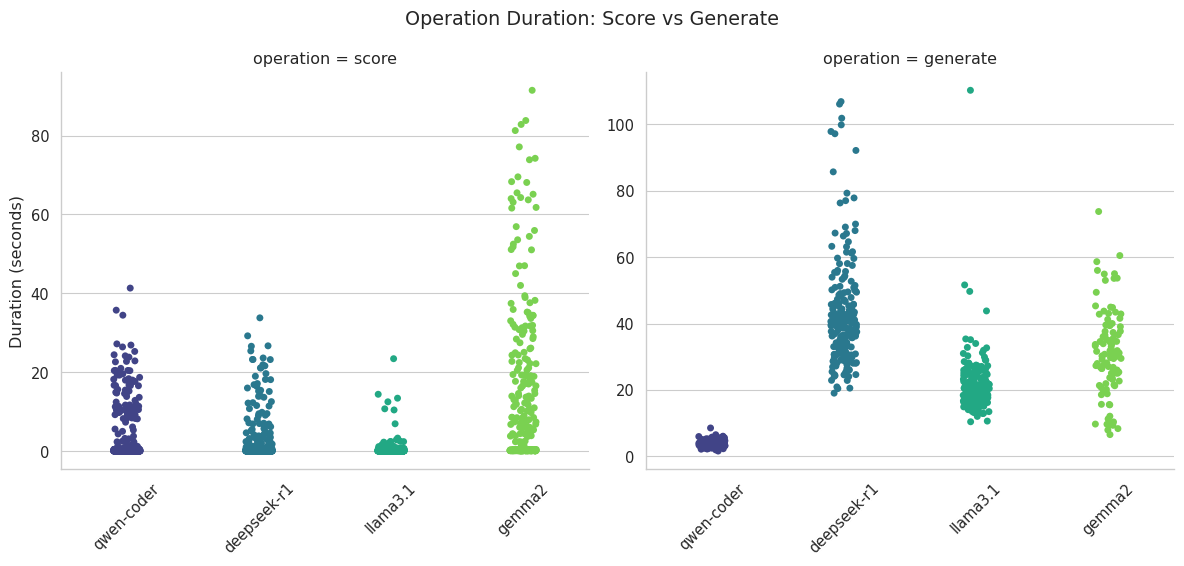

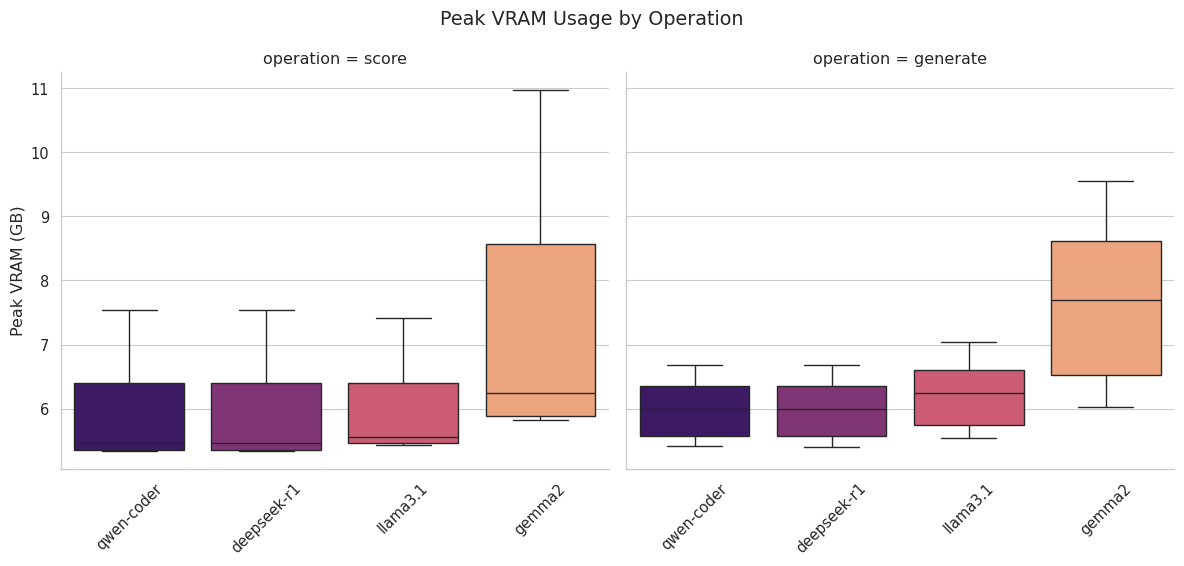

In [542]:
if not df_metrics.empty:
    g = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='duration_sec', 
        col='operation',  # split for 'score' and 'generate'
        kind='strip', #'box',
        hue='model_id', 
        palette='viridis', 
        height=5, 
        aspect=1.2,
        sharey=False      # Independent Y-axis
    )
    g.figure.suptitle('Operation Duration: Score vs Generate', y=1.05)
    g.set_axis_labels("", "Duration (seconds)")
    g.set_xticklabels(rotation=45)
    
    g_vram = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='peak_vram_gb',
        col='operation',
        kind='box', 
        hue='model_id', 
        palette='magma', 
        height=5, 
        aspect=1.2
    )
    g_vram.figure.suptitle('Peak VRAM Usage by Operation', y=1.05)
    g_vram.set_axis_labels("", "Peak VRAM (GB)")
    g_vram.set_xticklabels(rotation=45)
    # for ax in g_vram.axes.flat:
    #     ax.axhline(16, color='red', linestyle='--', linewidth=2, label='Limit VRAM')
        

    plt.show()
else:
    print("No metrics data found.")

## Generation study

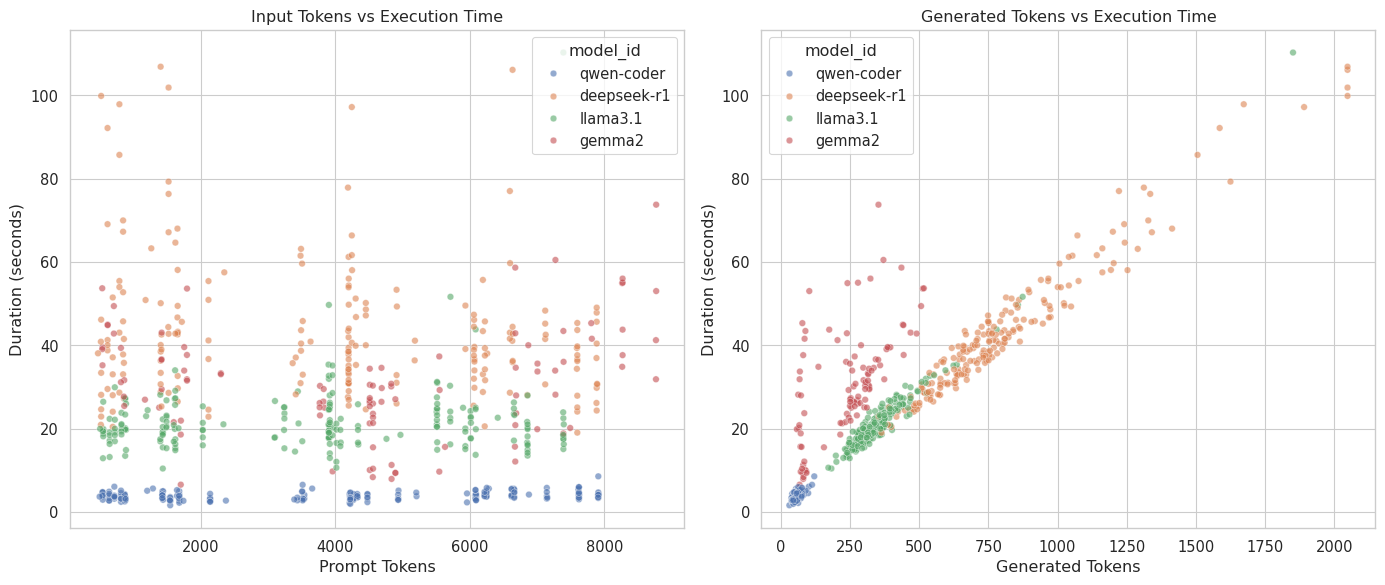

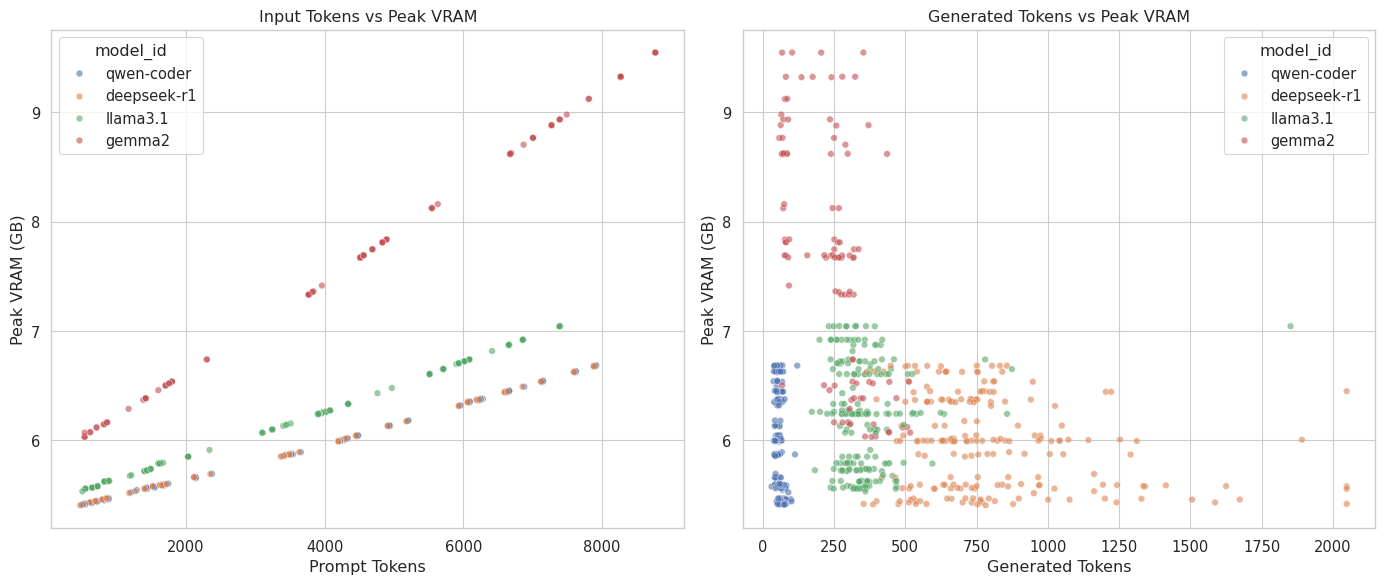

In [543]:
df_gen = df_metrics[df_metrics['operation'] == 'generate'].copy()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='duration_sec', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Execution Time')
plt.xlabel('Prompt Tokens')
plt.ylabel('Duration (seconds)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='generated_tokens', y='duration_sec', hue='model_id', alpha=0.6)
plt.title('Generated Tokens vs Execution Time')
plt.xlabel('Generated Tokens')
plt.ylabel('Duration (seconds)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='peak_vram_gb', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Peak VRAM')
plt.xlabel('Prompt Tokens')
plt.ylabel('Peak VRAM (GB)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='generated_tokens', y='peak_vram_gb', hue='model_id', alpha=0.6)
plt.title('Generated Tokens vs Peak VRAM')
plt.xlabel('Generated Tokens')
plt.ylabel('Peak VRAM (GB)')

plt.tight_layout()
plt.show()



## Score study

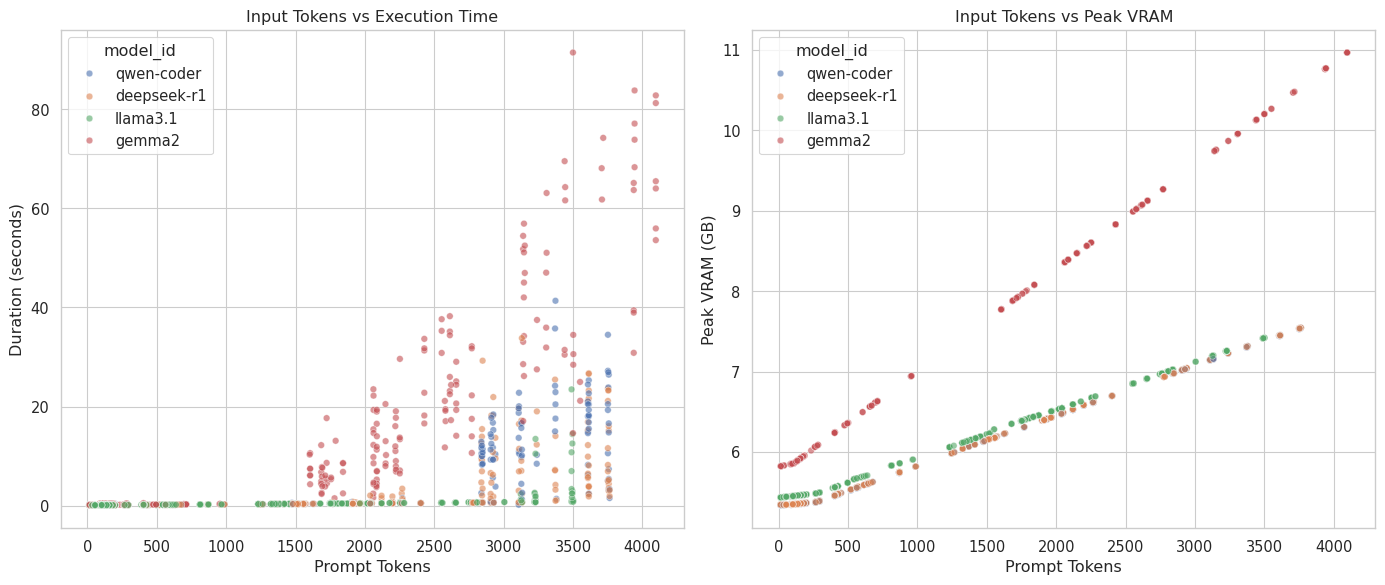

In [544]:
df_gen = df_metrics[df_metrics['operation'] == 'score'].copy()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='duration_sec', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Execution Time')
plt.xlabel('Prompt Tokens')
plt.ylabel('Duration (seconds)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='peak_vram_gb', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Peak VRAM')
plt.xlabel('Prompt Tokens')
plt.ylabel('Peak VRAM (GB)')


plt.tight_layout()
plt.show()

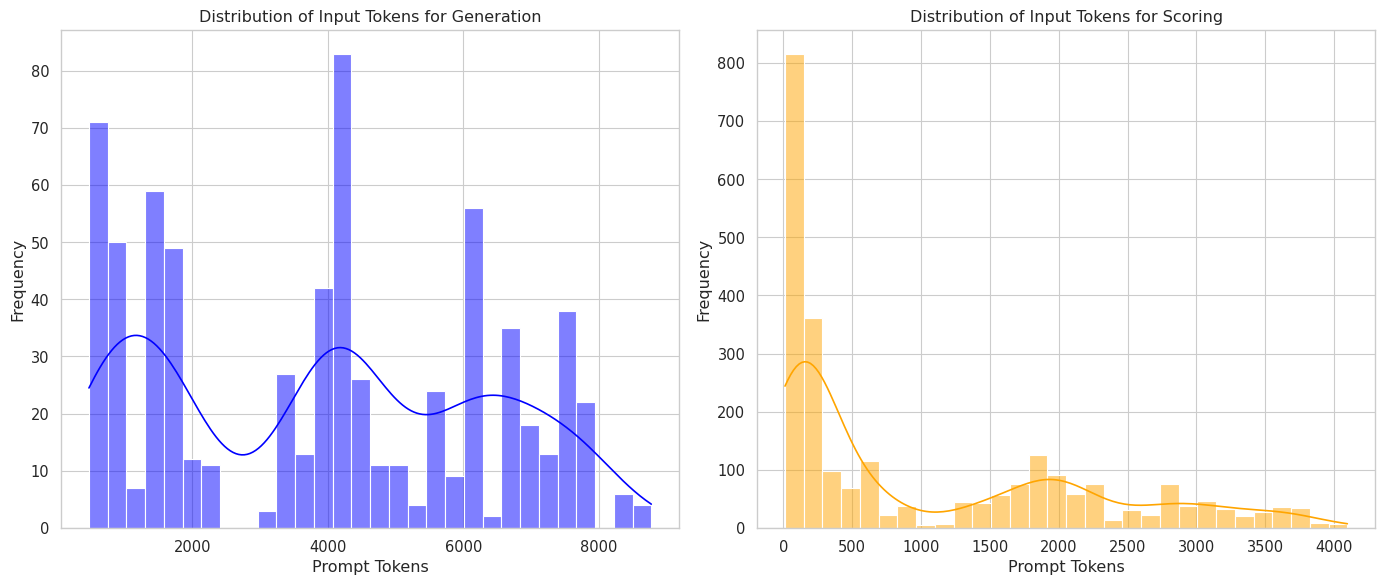

In [545]:
#distribution token input generation vs score
df_gen = df_metrics[df_metrics['operation'] == 'generate'].copy()
df_score = df_metrics[df_metrics['operation'] == 'score'].copy()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_gen, x='prompt_tokens', bins=30, kde=True, color='blue')
plt.title('Distribution of Input Tokens for Generation')
plt.xlabel('Prompt Tokens')
plt.ylabel('Frequency') 

plt.subplot(1, 2, 2)
sns.histplot(data=df_score, x='prompt_tokens', bins=30, kde=True, color='orange')
plt.title('Distribution of Input Tokens for Scoring')
plt.xlabel('Prompt Tokens')
plt.ylabel('Frequency') 
plt.tight_layout()
plt.show()

# Reports study

### Generation humanity

In [546]:
import re

def load_reports_new_format(path_pattern):
    all_records = []
    files = glob.glob(path_pattern)
    
    print(f"Found {len(files)} report files.")
    
    for f_path in files:
        try:
            with open(f_path, 'r') as f:
                data = json.load(f)
            
            pr_number = data.get('pr', 'unknown')
            
            results_dict = data.get('results', {})
            
            for model_id, items in results_dict.items():
                for item in items:
                    metrics = item.get('metrics', {})
                    
                    base_ppl = metrics.get('base_ppl', -1)
                    pr_ppl = metrics.get('pr_ppl', -1)
                    source_ppl = metrics.get('source_ppl', -1)
                    delta_ppl = metrics.get('delta_ppl', 0)

                    ast_base_ppl = metrics.get('base_ast_ppl', -1)
                    ast_pr_ppl = metrics.get('pr_ast_ppl', -1)
                    ast_source_ppl = metrics.get('source_ast_ppl', -1)
                    
                    if base_ppl == -1 or pr_ppl == -1:
                        continue

                    llm_qualitative = item.get('llm_qualitative', {})

                    if 'error' in llm_qualitative:
                        continue

                    qual_winner = llm_qualitative.get('winner')
                    if qual_winner == 'Unknown':
                        continue
                    if qual_winner == 'Error':
                        motivation = llm_qualitative.get('motivation', '')
                        
                        winner_match = re.search(r'"winner"\s*:\s*"([^"]+)"', motivation, flags=re.IGNORECASE)
                        if winner_match:
                            qual_winner = winner_match.group(1)
                            #print(f"Extracted winner from motivation: {qual_winner}")
                        else:
                            continue
                        
                        motivation_match = re.search(r'"\s*motivation\s*"\s*:\s*"([^"]+)"', motivation, flags=re.IGNORECASE)
                        if motivation_match:
                            motivation = motivation_match.group(1)
                        else:
                            motivation = ''
                        
                    llm_ast_qualitative = item.get('llm_ast', {})
                    if 'error' in llm_ast_qualitative:
                        continue
                    qual_ast_winner = llm_ast_qualitative.get('winner', 'tie')
                    if qual_ast_winner == 'Unknown':
                        continue
                    if qual_ast_winner == 'Error':
                        motivation = llm_ast_qualitative.get('motivation', '')
                        
                        winner_match = re.search(r'"winner"\s*:\s*"([^"]+)"', motivation, flags=re.IGNORECASE)
                        if winner_match:
                            qual_ast_winner = winner_match.group(1)
                            #print(f"Extracted AST winner from motivation: {qual_ast_winner}")
                        else:
                            continue
                        
                        motivation_match = re.search(r'"\s*motivation\s*"\s*:\s*"([^"]+)"', motivation, flags=re.IGNORECASE)
                        if motivation_match:
                            motivation = motivation_match.group(1)
                        else:
                            motivation = ''

                    source_len = len(item.get('source_code', ''))
                    base_len = len(item.get('function_base', ''))
                    pr_len = len(item.get('function_pr', ''))

                    source_ast = item.get('source_ast', '')
                    base_ast = item.get('base_ast', '')
                    pr_ast = item.get('pr_ast', '')
                    
                    record = {
                        'pr': pr_number,
                        'model': model_id,
                        'binary': item.get('binary'),
                        'function': item.get('function'),
                        'source_ast': source_ast,
                        'base_ast': base_ast,
                        'pr_ast': pr_ast,
                        # Quantitative Metrics
                        'base_ppl': base_ppl,
                        'pr_ppl': pr_ppl,
                        'delta_ppl': delta_ppl,
                        'source_ppl': source_ppl,
                        'ast_base_ppl': ast_base_ppl if ast_base_ppl != -1 else np.nan,
                        'ast_pr_ppl': ast_pr_ppl if ast_pr_ppl != -1 else np.nan,
                        'ast_source_ppl': ast_source_ppl if ast_source_ppl != -1 else np.nan,
                        'ast_delta_ppl': ast_pr_ppl - ast_base_ppl if ast_base_ppl != -1 and ast_pr_ppl != -1 else np.nan,
                        
                        # Qualitative Metrics
                        'qualitative_winner': qual_winner,
                        'qualitative_ast_winner': qual_ast_winner,
                        'source_len': source_len,
                        'len_change': pr_len - base_len,
                        'is_improvement': delta_ppl < 0
                    }
                    all_records.append(record)
                    
        except Exception as e:
            print(f"Error loading {f_path}: {e}")

    df = pd.DataFrame(all_records)
    return df

df_reports = load_reports_new_format(REPORTS_PATH)
print(f"Loaded {len(df_reports)} valid records after filtering errors.")
df_reports.head()

Found 9 report files.
Loaded 305 valid records after filtering errors.


,pr,model,binary,function,source_ast,base_ast,pr_ast,base_ppl,pr_ppl,delta_ppl,source_ppl,ast_base_ppl,ast_pr_ppl,ast_source_ppl,ast_delta_ppl,qualitative_winner,qualitative_ast_winner,source_len,len_change,is_improvement
0,7253,qwen-coder,task-libxls_xls_parseWorkBook-O2.so,xls_parseWorkBook,{if()call()do_while(){if(){call()call()}if(){g...,{if(){}else{call()do_while(){if(){call()call()...,{if(){}else{call()do_while(){if(){call()call()...,2.000000,2.015625,0.015625,2.484375,3.484375,3.468750,4.187500,-0.015625,TIE,BASE,6867,27,False
1,7253,qwen-coder,task-libxls_xls_parseWorkBook-O3.so,xls_parseWorkBook,{if()call()do_while(){if(){call()call()}if(){g...,{if(){}else{call()do_while(){if(){call()call()...,{if(){}else{call()do_while(){if(){call()call()...,2.000000,2.015625,0.015625,2.484375,3.484375,3.468750,4.187500,-0.015625,TIE,BASE,6867,27,False
2,7253,qwen-coder,task-file_file_signextend-O0.so,file_signextend,{if(){switch(){case:call()case:case:case:call(...,{if(){switch(){case:case:case:case:case:case:c...,{if(){switch(){case:case:case:case:case:case:c...,2.171875,2.171875,0.000000,2.921875,1.664062,1.664062,1.976562,0.000000,TIE,TIE,1783,0,False
3,7253,qwen-coder,task-file_file_signextend-O2.so,file_signextend,{if(){switch(){case:call()case:case:case:call(...,{if(){switch(){case:case:case:case:case:case:c...,{if(){switch(){case:case:case:case:case:case:c...,1.757812,1.765625,0.007812,2.921875,1.664062,1.664062,1.976562,0.000000,PR,TIE,1783,0,False
4,7253,qwen-coder,task-file_file_signextend-O3.so,file_signextend,{if(){switch(){case:call()case:case:case:call(...,{if(){switch(){case:case:case:case:case:case:c...,{if(){switch(){case:case:case:case:case:case:c...,1.757812,1.765625,0.007812,2.921875,1.664062,1.664062,1.976562,0.000000,PR,TIE,1783,0,False


## Perplexity

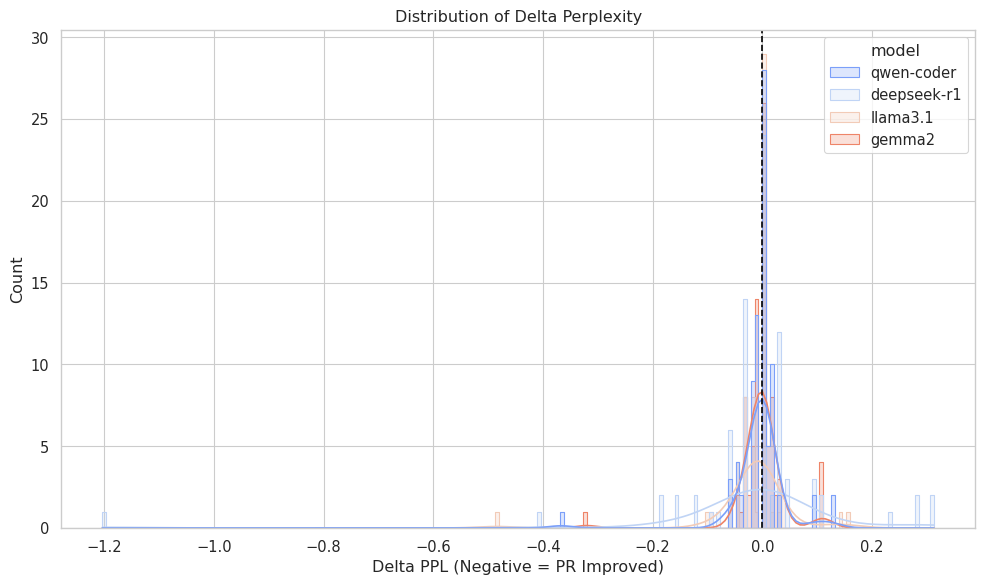

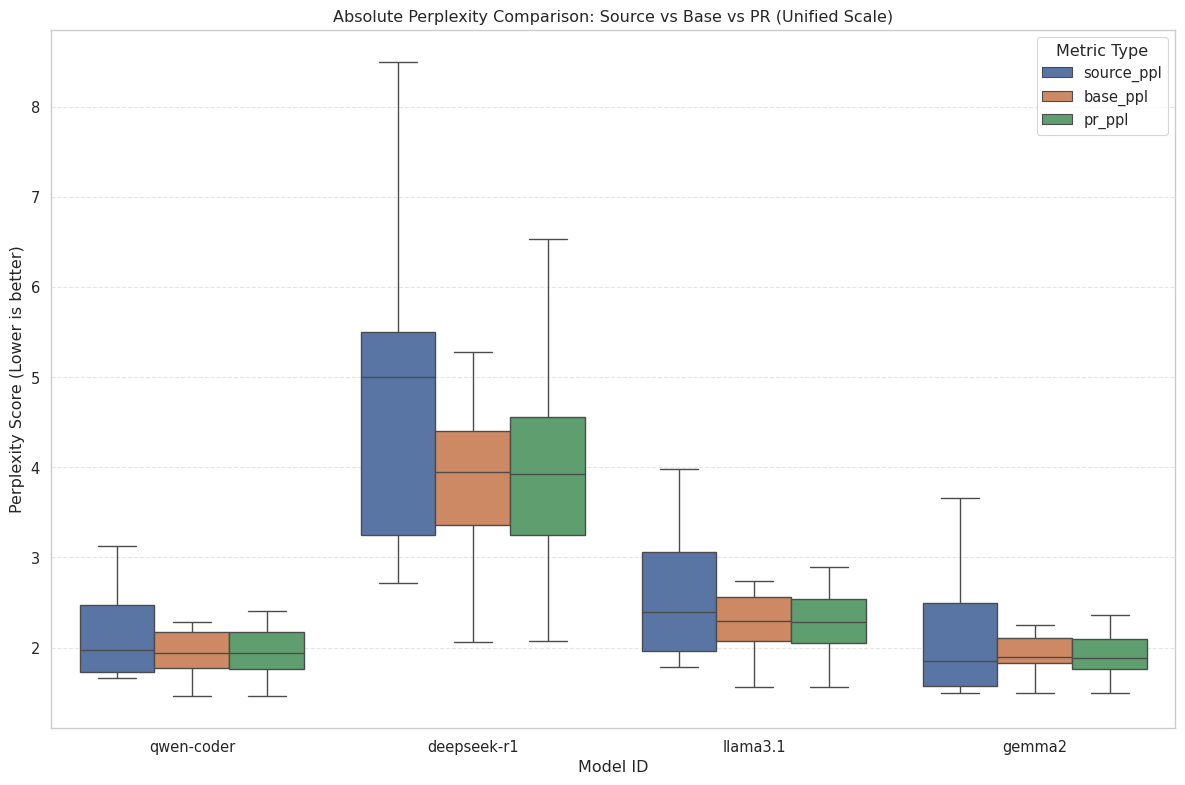

In [547]:
if not df_reports.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df_reports, 
        x='delta_ppl', 
        hue='model', 
        kde=True, 
        element="step", 
        palette='coolwarm'
    )
    plt.title('Distribution of Delta Perplexity')
    plt.xlabel('Delta PPL (Negative = PR Improved)')
    plt.axvline(0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()

   
    df_long = df_reports.melt(
        id_vars=['model'], 
        value_vars=['source_ppl', 'base_ppl', 'pr_ppl'],
        var_name='metric_type', 
        value_name='perplexity'
    )
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        data=df_long, 
        x='model', 
        y='perplexity', 
        hue='metric_type', 
        showfliers=False
    )
    
    plt.title('Absolute Perplexity Comparison: Source vs Base vs PR (Unified Scale)')
    plt.ylabel('Perplexity Score (Lower is better)')
    plt.xlabel('Model ID')
    plt.legend(title='Metric Type')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



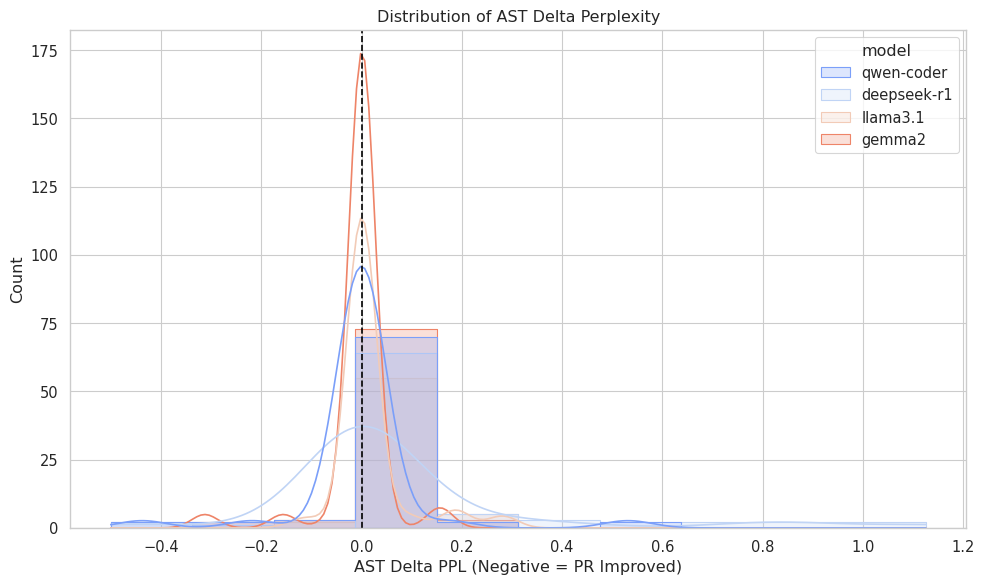

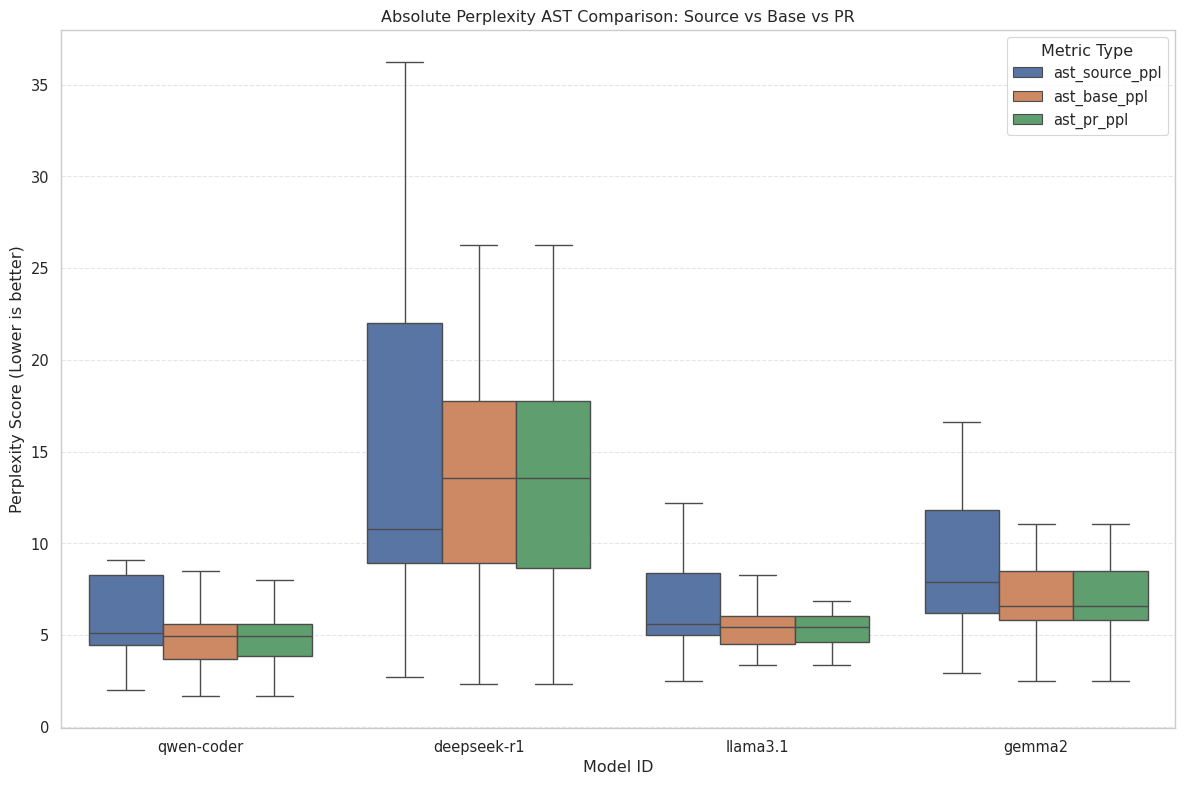

In [548]:
if not df_reports.empty:
    df_ast_valid = df_reports.dropna(subset=['ast_delta_ppl'])

    if not (df_ast_valid['ast_delta_ppl'] == 0).all():
        group_vars = df_ast_valid.groupby('model')['ast_delta_ppl'].var()
        is_singular = (group_vars.fillna(0) == 0).any()
        
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=df_ast_valid, 
            x='ast_delta_ppl', 
            hue='model', 
            kde=not is_singular,
            element="step", 
            palette='coolwarm'
        )
        plt.title('Distribution of AST Delta Perplexity')
        plt.xlabel('AST Delta PPL (Negative = PR Improved)')
        plt.axvline(0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("AST Delta PPL is singular for all models; skipping plot. (no variance troughout AST data)")

   
    df_long = df_reports.melt(
        id_vars=['model'], 
        value_vars=['ast_source_ppl', 'ast_base_ppl', 'ast_pr_ppl'],
        var_name='metric_type', 
        value_name='perplexity'
    )
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        data=df_long, 
        x='model', 
        y='perplexity', 
        hue='metric_type',
        showfliers=False
    )
    
    plt.title('Absolute Perplexity AST Comparison: Source vs Base vs PR')
    plt.ylabel('Perplexity Score (Lower is better)')
    plt.xlabel('Model ID')
    plt.legend(title='Metric Type')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



### Perplexity trough PRs

Generating plots for 4 unique PRs...


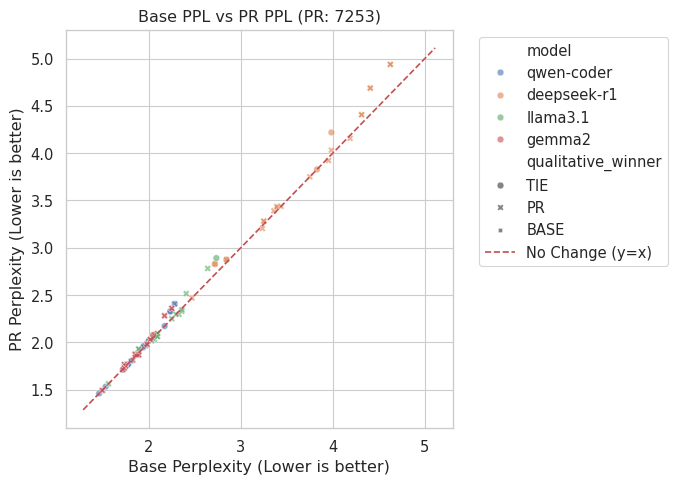

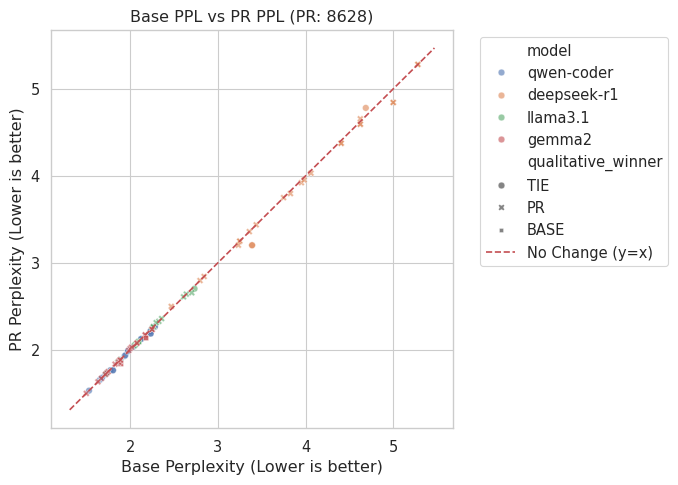

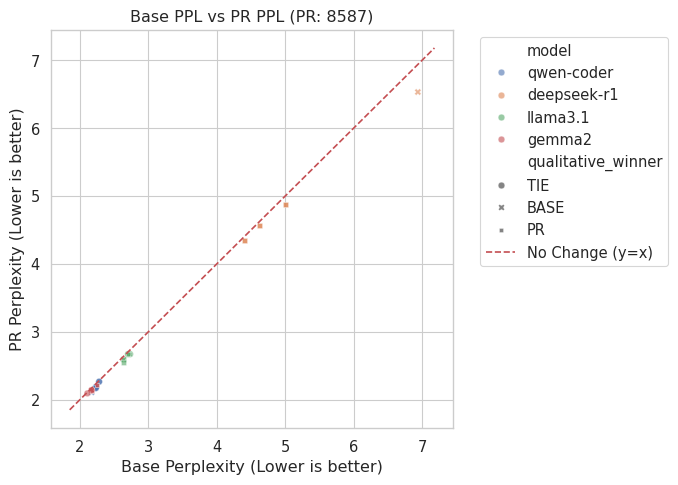

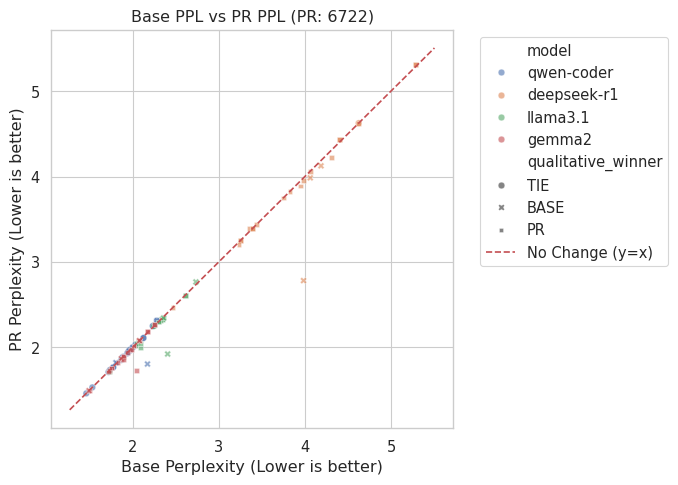

In [549]:
unique_prs = df_reports['pr'].unique()

print(f"Generating plots for {len(unique_prs)} unique PRs...")

for pr_id in unique_prs:
    df_pr = df_reports[df_reports['pr'] == pr_id]
    
    if df_pr.empty:
        continue

    plt.figure(figsize=(7, 5))
    
    sns.scatterplot(
        data=df_pr, 
        x='base_ppl', 
        y='pr_ppl', 
        hue='model', 
        alpha=0.6,
        style='qualitative_winner' 
    )

    curr_min_base = df_pr['base_ppl'].min()
    curr_min_pr = df_pr['pr_ppl'].min()
    curr_max_base = df_pr['base_ppl'].max()
    curr_max_pr = df_pr['pr_ppl'].max()
    
    min_val = min(curr_min_base, curr_min_pr)
    max_val = max(curr_max_base, curr_max_pr)
    
    margin = (max_val - min_val) * 0.05 if max_val != min_val else 1.0
    
    plt.plot(
        [min_val - margin, max_val + margin], 
        [min_val - margin, max_val + margin], 
        'r--', 
        label='No Change (y=x)'
    )

    plt.title(f'Base PPL vs PR PPL (PR: {pr_id})')
    plt.xlabel('Base Perplexity (Lower is better)')
    plt.ylabel('PR Perplexity (Lower is better)')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### Check length Bias

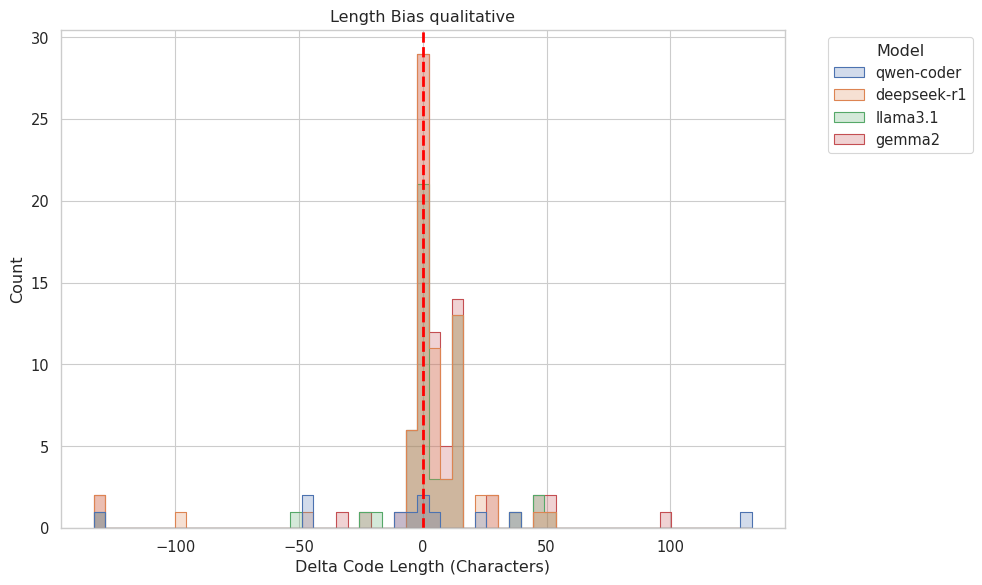

Average Length Bias: 2.09 chars (Positive = prefers longer, Negative = prefers shorter)


In [550]:
df_bias = df_reports.copy()

valid_pr_labels = ['pr',]
valid_base_labels = ['base']

df_bias['qualitative_winner'] = df_bias['qualitative_winner'].astype(str).str.lower().str.strip()

mask_valid = df_bias['qualitative_winner'].isin(valid_pr_labels + valid_base_labels)
df_bias = df_bias[mask_valid].copy()


def get_winner_len_delta(row):
    w = row['qualitative_winner']
    if w in valid_pr_labels:
        return row['len_change']
    elif w in valid_base_labels:
        return -row['len_change']
    return None

df_bias['delta_len_winner'] = df_bias.apply(get_winner_len_delta, axis=1)

df_bias = df_bias.dropna(subset=['delta_len_winner'])

plt.figure(figsize=(10, 6))

ax = sns.histplot(
    data=df_bias, 
    x='delta_len_winner', 
    hue='model', 
    element="step", 
    #kde=True,
    #palette='viridis'
)

plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No Length Diff')

plt.title('Length Bias qualitative')
plt.xlabel('Delta Code Length (Characters)')
plt.ylabel('Count')
try:
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), title='Model')
except AttributeError:
    # Fallback 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')
plt.tight_layout()
plt.show()

mean_bias = df_bias['delta_len_winner'].mean()
print(f"Average Length Bias: {mean_bias:.2f} chars (Positive = prefers longer, Negative = prefers shorter)")

In [551]:
# plt.figure(figsize=(12, 6))
    
# sns.boxenplot(
#     data=df_reports,
#     x='qualitative_winner', 
#     y='len_change',
#     hue='model',
#     palette='muted'
# )

# plt.axhline(0, color='black', linestyle='--', label='Same Length')
# plt.title('Qualitative: Does Code Length affect the Winner?')
# plt.xlabel('Who Won?')
# plt.ylabel('Length Change in PR (Negative = PR is Shorter)')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

## Check position Bias

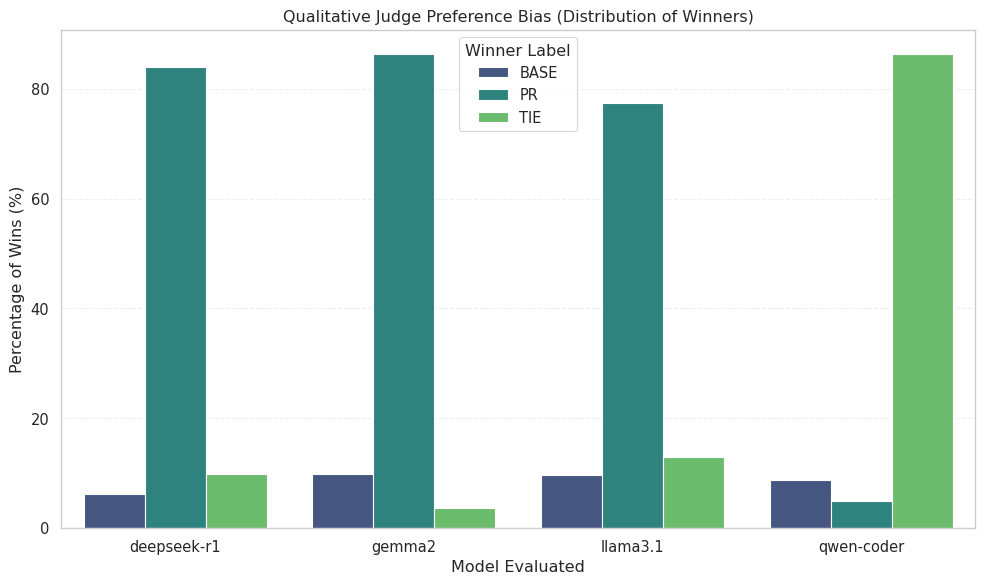

In [552]:
plt.figure(figsize=(10, 6))
    
bias_counts = df_reports.groupby(['model', 'qualitative_winner']).size().reset_index(name='count')
total_counts = df_reports.groupby('model').size().reset_index(name='total')
bias_data = bias_counts.merge(total_counts, on='model')
bias_data['percentage'] = bias_data['count'] / bias_data['total'] * 100

sns.barplot(
    data=bias_data,
    x='model',
    y='percentage',
    hue='qualitative_winner',
    palette='viridis'
)

plt.title('Qualitative Judge Preference Bias (Distribution of Winners)')
plt.ylabel('Percentage of Wins (%)')
plt.xlabel('Model Evaluated')
plt.legend(title='Winner Label')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Coherence ad alignment

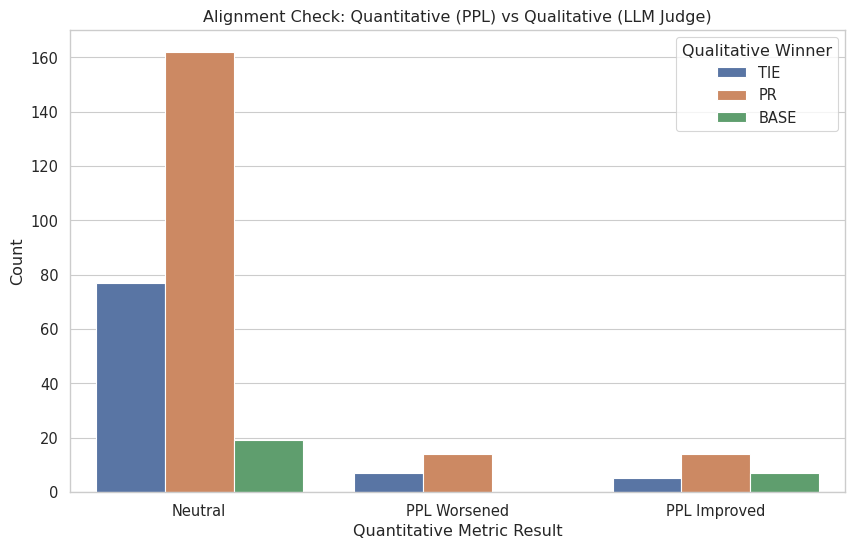

In [553]:
LAMBDA = 0.05

df_reports['quantitative_result'] = df_reports['delta_ppl'].apply(lambda x: 'PPL Improved' if x < -LAMBDA else ('PPL Worsened' if x > LAMBDA else 'Neutral'))

plt.figure(figsize=(10, 6))
sns.countplot(data=df_reports, x='quantitative_result', hue='qualitative_winner')
plt.title('Alignment Check: Quantitative (PPL) vs Qualitative (LLM Judge)')
plt.xlabel('Quantitative Metric Result')
plt.ylabel('Count')
plt.legend(title='Qualitative Winner')
plt.show()

=== Coherence Analysis (Base) ===


,Model,Total Cases Win,Consistent Winners,Consistency Rate
0,deepseek-r1,23,1,0.043478
1,gemma2,21,0,0.000000
2,llama3.1,6,1,0.166667
3,qwen-coder,6,2,0.333333


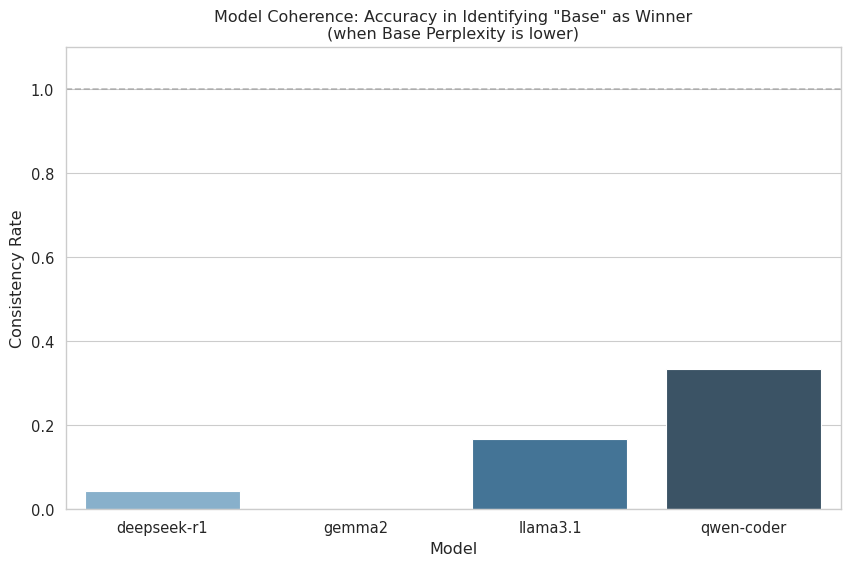

=== Coherence Analysis (PR) ===


,Model,Total Cases Win,Consistent Winners,Consistency Rate
0,deepseek-r1,28,28,1.0
1,gemma2,31,31,1.0
2,llama3.1,23,23,1.0
3,qwen-coder,2,2,1.0


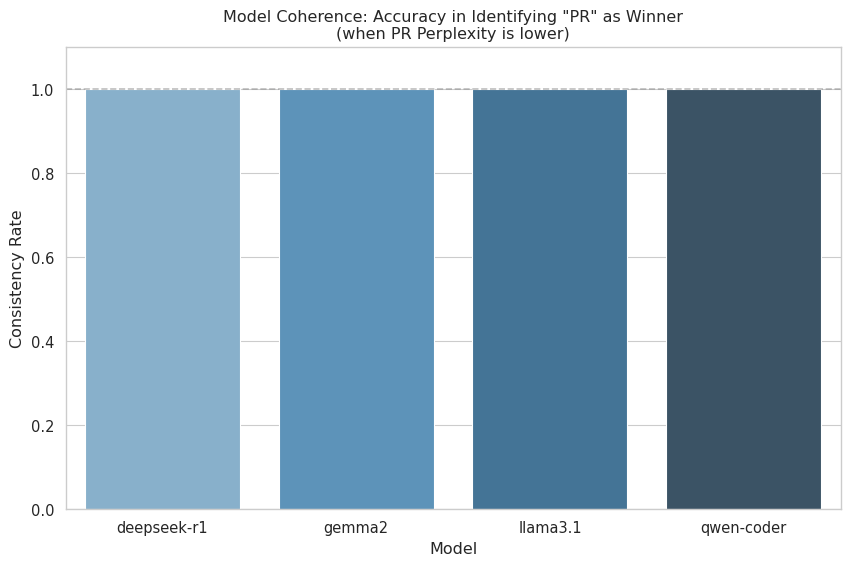

In [554]:
def analyze_coherence(df_reports, title, winner_labels, is_lower):
    if not df_reports.empty:
        
        # Base is better when is_lower is True
        base_better_mask = df_reports['delta_ppl'] > 0 if is_lower else df_reports['delta_ppl'] < 0
        df_consistency = df_reports[base_better_mask].copy()

        df_consistency = df_consistency[
            ~df_consistency['qualitative_winner'].astype(str).str.lower().isin(['tie', 'none', 'unknown'])
        ]

        valid_base_winners = winner_labels
        
        df_consistency['is_consistent'] = df_consistency['qualitative_winner'].apply(
            lambda x: any(k in str(x) for k in valid_base_winners)
        )
        
        # Calculate Consistency Rate per Model
        coherence_stats = df_consistency.groupby('model')['is_consistent'].agg(['count', 'sum', 'mean']).reset_index()
        coherence_stats.columns = ['Model', 'Total Cases Win', 'Consistent Winners', 'Consistency Rate']
        
        print(f"=== Coherence Analysis ({'Base' if is_lower else 'PR'}) ===")
        display(coherence_stats)
        
        # Plotting Consistency
        plt.figure(figsize=(10, 6))
        sns.barplot(data=coherence_stats, x='Model', hue='Model', y='Consistency Rate', palette='Blues_d', legend=False)
        plt.title(f'Model Coherence: Accuracy in Identifying {title}')
        plt.ylim(0, 1.1)
        plt.ylabel('Consistency Rate')
        plt.axhline(1.0, linestyle='--', color='grey', alpha=0.5)
        plt.show()


obj = [{
    "title":'"Base" as Winner\n(when Base Perplexity is lower)',
    "winner": ['A', 'Base'],
    "islower": True
},
{
    "title":'"PR" as Winner\n(when PR Perplexity is lower)',
    "winner": ['B', 'PR'],
    "islower": False
}]

for item in obj:
    analyze_coherence(df_reports, item['title'], item['winner'], item['islower'])

In [555]:
if not df_reports.empty:
    print(f"=== Top 20 Functions with Highest Perplexity Change for Model: ===")
    unique_models = df_reports['model'].unique()
    df_consistency = df_reports[
        ~df_reports['qualitative_winner'].astype(str).str.lower().isin(['tie', 'none', 'unknown'])
    ]
    for model in unique_models:
        print(f"\n--- Model: {model} ---")
        df_model = df_consistency[df_consistency['model'] == model]
        df_model = df_model.assign(abs_delta=df_model['delta_ppl'].abs())
        
        top_changes = df_model.sort_values('abs_delta', ascending=False).head(20)
        
        cols = ['pr', 'binary', 'function', 'abs_delta', 'delta_ppl', 'qualitative_winner']
        
        # Styling the table for readability
        styled_table = top_changes[cols].style.background_gradient(
            subset=['abs_delta'], cmap='RdBu_r'
        ).format({'abs_delta': "{:.4f}"})
        
        display(styled_table)

=== Top 20 Functions with Highest Perplexity Change for Model: ===

--- Model: qwen-coder ---


,pr,binary,function,abs_delta,delta_ppl,qualitative_winner
214,6722,task-file_file_signextend-O0.so,file_signextend,0.3672,-0.367188,BASE
15,7253,task-readstat_dta_parse_timestamp-O3.so,dta_parse_timestamp,0.1250,0.125000,PR
190,8587,task-file_file_replace-O0.so,file_replace,0.0625,-0.062500,BASE
222,6722,task-readstat_dta_parse_timestamp-O2.so,dta_parse_timestamp,0.0312,0.031250,BASE
228,6722,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.0156,0.015625,PR
229,6722,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.0156,0.015625,BASE
3,7253,task-file_file_signextend-O2.so,file_signextend,0.0078,0.007812,PR
4,7253,task-file_file_signextend-O3.so,file_signextend,0.0078,0.007812,PR
5,7253,task-libxls_xls_parseWorkBook-O0.so,xls_parseWorkBook,0.0000,0.000000,BASE
20,7253,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.0000,0.000000,BASE



--- Model: deepseek-r1 ---


,pr,binary,function,abs_delta,delta_ppl,qualitative_winner
238,6722,task-file_file_signextend-O0.so,file_signextend,1.2031,-1.203125,BASE
197,8587,task-file_file_replace-O0.so,file_replace,0.4062,-0.406250,BASE
40,7253,task-readstat_dta_parse_timestamp-O3.so,dta_parse_timestamp,0.3125,0.312500,PR
39,7253,task-readstat_dta_parse_timestamp-O2.so,dta_parse_timestamp,0.3125,0.312500,PR
42,7253,task-readstat_sav_parse_date-O3.so,sav_parse_date,0.2812,0.281250,PR
41,7253,task-readstat_sav_parse_date-O2.so,sav_parse_date,0.2812,0.281250,PR
141,8628,task-readstat_sav_parse_time-O3.so,sav_parse_time,0.1562,-0.156250,PR
140,8628,task-readstat_sav_parse_time-O2.so,sav_parse_time,0.1562,-0.156250,PR
196,8587,task-readstat_sav_parse_time-O3.so,sav_parse_time,0.1250,-0.125000,PR
195,8587,task-readstat_sav_parse_time-O2.so,sav_parse_time,0.1250,-0.125000,PR



--- Model: llama3.1 ---


,pr,binary,function,abs_delta,delta_ppl,qualitative_winner
263,6722,task-file_file_signextend-O0.so,file_signextend,0.4844,-0.484375,BASE
61,7253,task-readstat_sav_parse_date-O2.so,sav_parse_date,0.1406,0.140625,PR
50,7253,task-file_file_signextend-O0.so,file_signextend,0.1094,0.109375,PR
273,6722,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.1016,-0.101562,PR
204,8587,task-file_file_replace-O0.so,file_replace,0.0938,-0.093750,PR
199,8587,task-readstat_dta_parse_timestamp-O3.so,dta_parse_timestamp,0.0625,-0.062500,PR
200,8587,task-readstat_sav_parse_date-O2.so,sav_parse_date,0.0469,-0.046875,PR
159,8628,task-readstat_sav_parse_time-O2.so,sav_parse_time,0.0469,-0.046875,PR
278,6722,task-xz_lzma_index_hash_decode-O0.so,lzma_index_hash_decode,0.0469,-0.046875,PR
201,8587,task-readstat_sav_parse_date-O3.so,sav_parse_date,0.0469,-0.046875,BASE



--- Model: gemma2 ---


,pr,binary,function,abs_delta,delta_ppl,qualitative_winner
282,6722,task-file_file_signextend-O0.so,file_signextend,0.3203,-0.320312,PR
82,7253,task-readstat_dta_parse_timestamp-O2.so,dta_parse_timestamp,0.1094,0.109375,PR
84,7253,task-readstat_sav_parse_date-O2.so,sav_parse_date,0.1094,0.109375,PR
85,7253,task-readstat_sav_parse_date-O3.so,sav_parse_date,0.1094,0.109375,PR
83,7253,task-readstat_dta_parse_timestamp-O3.so,dta_parse_timestamp,0.1094,0.109375,PR
173,8628,task-xz_lzma_validate_chain-O3.so,lzma_validate_chain,0.0469,-0.046875,PR
172,8628,task-xz_lzma_validate_chain-O2.so,lzma_validate_chain,0.0469,-0.046875,BASE
303,6722,task-xz_lzma_index_hash_decode-O0.so,lzma_index_hash_decode,0.0391,-0.039062,PR
205,8587,task-readstat_dta_parse_timestamp-O2.so,dta_parse_timestamp,0.0312,-0.031250,PR
72,7253,task-file_file_signextend-O3.so,file_signextend,0.0312,0.031250,PR


## generation ast study

In [562]:
#count how many winner ast that arent tie there are
len(df_reports[~df_reports['qualitative_ast_winner'].str.lower().isin(['tie','source'])])

52

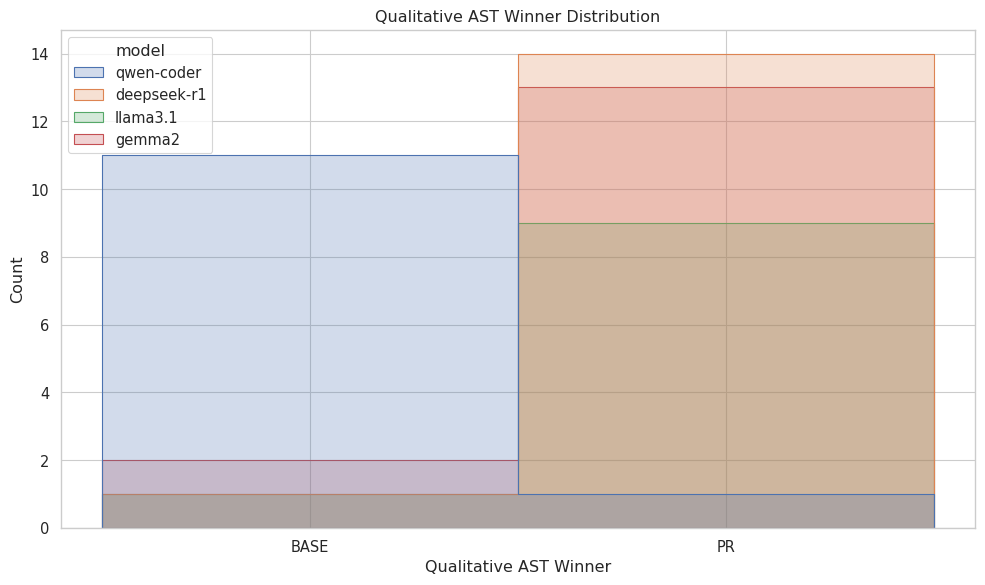

In [567]:
df_clean = df_reports[~df_reports['qualitative_ast_winner'].str.lower().isin(['tie','source'])].copy()
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_clean, 
    x='qualitative_ast_winner', 
    hue='model', 
    element="step", 
    #kde=True,
    #palette='viridis'
)

plt.title('Qualitative AST Winner Distribution')
plt.xlabel('Qualitative AST Winner')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

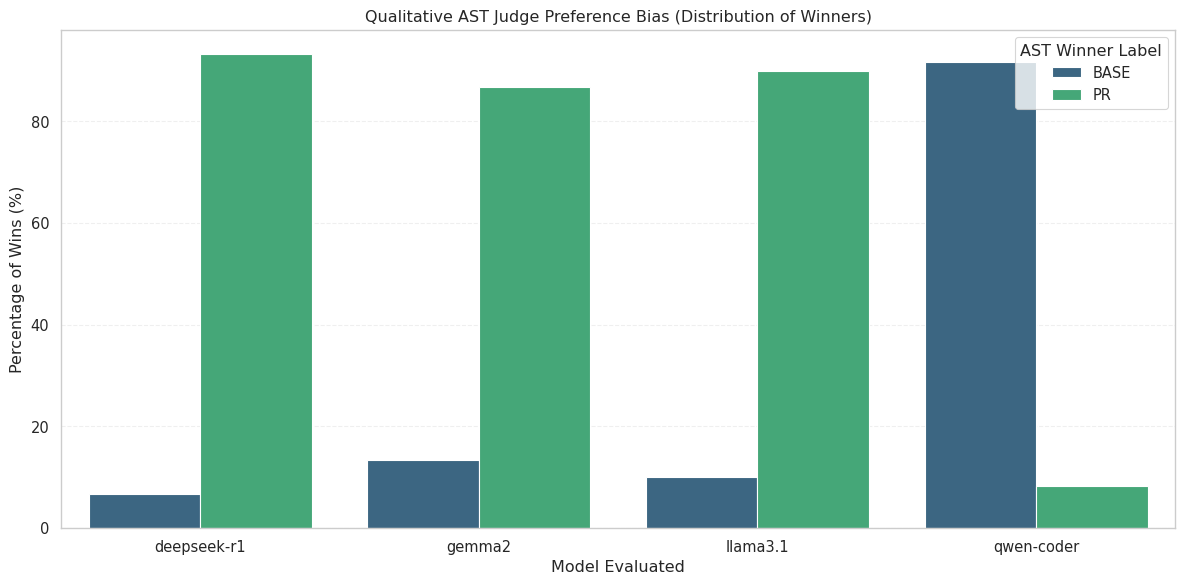

In [568]:
#distribution of winner ast qualitative roe each model
bias_data = df_clean.groupby(['model', 'qualitative_ast_winner']).size().reset_index(name='count')
total_counts = df_clean.groupby('model').size().reset_index(name='total')
bias_data = bias_data.merge(total_counts, on='model')
bias_data['percentage'] = bias_data['count'] / bias_data['total'] * 100

sns.barplot(
    data=bias_data,
    x='model',
    y='percentage',
    hue='qualitative_ast_winner',
    palette='viridis'
)   
plt.title('Qualitative AST Judge Preference Bias (Distribution of Winners)')
plt.ylabel('Percentage of Wins (%)')
plt.xlabel('Model Evaluated')
plt.legend(title='AST Winner Label')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [560]:
#print ast when winner is base or pr
for index, row in df_clean.iterrows():
    if row['qualitative_ast_winner'].lower() in ['base', 'pr']:
        print(f"Model: {row['model']}, Function: {row['function']}, AST Winner: {row['qualitative_ast_winner']}, pr: {row['pr']}")
        print("----SOURCE AST-----")
        print(row.get('source_ast', 'N/A'))
        print("----- BASE AST -----")
        print(row.get('base_ast', 'N/A'))
        print("----- PR AST -----")
        print(row.get('pr_ast', 'N/A'))
        print("--------------------\n")

Model: qwen-coder, Function: xls_parseWorkBook, AST Winner: BASE, pr: 7253
----SOURCE AST-----
{if()call()do_while(){if(){call()call()}if(){goto}call()if()call()if(){if(){if()call()goto}if(){if()call()goto}}if(){goto}switch(){case:case:if(){call((?::))call()}case:if()call()case:if(){if(){if()goto}}case:{call()if(){call()call()call()call()call()call()call()call()call()call()}}case:call()if(){goto}case:case:{call()if(){goto}}case:if(){call()if(){goto}if(){call()call()call()call()call()call()call()call()}}else{call()if(){goto}if(){call()}}case:case:{call()call()if(){call()call()call()call()call()call()call()call()if()call()}}case:call()if(){goto}case:if(){call()if(){call()call()}else{call()call()call()}}case:if(){for(){call()}}case:if(){call()}case:gotocase:if(){call()for()call()call()}case:if(){call()}}}if()call()}
----- BASE AST -----
{if(){}else{call()do_while(){if(){call()call()}call()if(){}call()if(){call()}if(){call()if(){if(){}call()}call()if(){if(){call()}goto}}call()if(){}if(){sw